# <span style="color:#0b486b">  FIT3181/5215: Deep Learning (2025)</span>
***
*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Clayton):* **A/Prof Zongyuan Ge** | zongyuan.ge@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Arghya Pal** | arghya.pal@monash.edu <br/>
 <br/>
*Head Tutor 3181:*  **Ms Ruda Nie H** |  \[RudaNie.H@monash.edu \] <br/>
*Head Tutor 5215:*  **Ms Leila Mahmoodi** |  \[leila.mahmoodi@monash.edu \]

<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">Tutorial 3b: Convolutional Neural Network with MiniVGG</span><span style="color:red;  font-size: 18px">***** (highly important)</span> #
**This tutorial applies CNN to a more real-world setting using PyTorch using the `CIFAR-10` dataset. It will cover the following**:
1. ***How to implement a simplified version of a real-world CNN named `MiniVGG` to classify the `CIFAR-10` dataset using PyTorch***.

VGGNet, (aka VGG), was first introduced by Simonyan and Zisserman in their 2014 paper, *Very Deep Learning Convolutional Neural Networks for Large-Scale Image Recognition*.
The work was the first to demonstrate that architecture with very small (3×3) filters can be successfully trained for very deep networks (16-19 layers) and obtain state-of-the-art classification on the challenging ImageNet classification challenge. <br/>

The VGG family of Convolutional Neural Networks can be characterized by two key components:
1. *All CONV layers in the network using only **3×3** filters.*
2. *Stacking multiple CONV => RELU layer sets (where the number of consecutive CONV => RELU layers normally increases as we go deeper) before applying a POOL operation.* <br/>

Due to the size of this architecture which compromises the running time, this tutorial will use `MiniVGG` which is a simplified version of `VGG` including its architecture, implementation, and application to the `CIFAR-10` dataset.

---

## <span style="color:#0b486b">I. MiniVGG for the CIFAR-10 dataset</span> ##

### <span style="color:#0b486b">I.1. Architecture of MiniVGG </span>
The following figure and table show the concrete architecture of `MiniVGG`. As mentioned before, `MiniVGG` only uses $3\times3$ filters. In addition, in the `MiniVGGNet`, we apply the batch norm technique to regularize the training and allow the network to be trained with a higher learning rate.

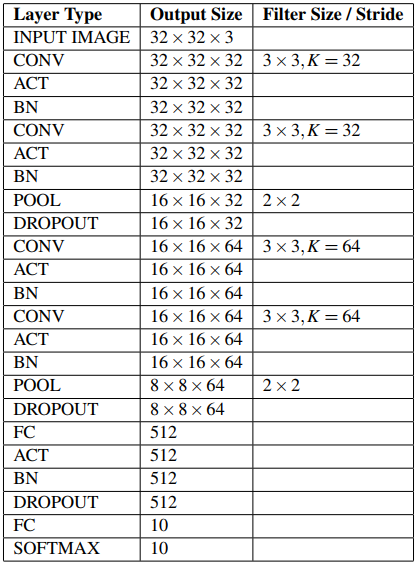

### <span style="color:#0b486b">I.2. Implementation of MiniVGG </span>

#### <span style="color:#0b486b">I.2.1 Import necessary packages and modules </span>

In [ ]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(123)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


We set the random seeds for `numpy` and `PyTorch` for the purpose of reproductivity of the experimental results

In [ ]:
np.random.seed(123)
torch.manual_seed(123)

#### <span style="color:#0b486b">I.2.2 Download, prepare and preprocess CIFAR-10 dataset </span>

The CIFAR-10 dataset contains `60,000` color images in `10` classes, with `6,000` images in each class. The dataset is divided into `50,000` training images and `10,000` testing images. The classes are mutually exclusive and there is no overlap between them.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
])

full_train_set = torchvision.datasets.CIFAR10("./data", download=True, transform=transform)
full_test_set = torchvision.datasets.CIFAR10("./data", download=True, train=False, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]


In [ ]:
print(full_train_set)
print(full_test_set)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


Create a tiny CIFAR10 dataset for the experiment.

In [ ]:
total_num_train = len(full_train_set)
total_num_test = len(full_test_set)
train_valid_idx = torch.randperm(total_num_train)
train_set = torch.utils.data.Subset(full_train_set, train_valid_idx[:5000])
valid_set = torch.utils.data.Subset(full_train_set, train_valid_idx[5000:10000])

test_idx = torch.randperm(total_num_test)
test_set = torch.utils.data.Subset(full_test_set, test_idx[:5000])

print("Traing set\n\t-Number of samples:\t{}\n\t-Shape of 1 sample:\t{}".format(len(train_set), list(train_set[0][0].shape)))
print("Valid set\n\t-Number of samples:\t{}\n\t-Shape of 1 sample:\t{}".format(len(valid_set), list(valid_set[0][0].shape)))
print("Test set\n\t-Number of samples:\t{}\n\t-Shape of 1 sample:\t{}".format(len(test_set), list(test_set[0][0].shape)))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32)

Traing set
	-Number of samples:	5000
	-Shape of 1 sample:	[3, 32, 32]
Valid set
	-Number of samples:	5000
	-Shape of 1 sample:	[3, 32, 32]
Test set
	-Number of samples:	5000
	-Shape of 1 sample:	[3, 32, 32]


In [ ]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

#### <span style="color:#0b486b">I.2.3 Visualize CIFAR-10 images </span>

In [ ]:
import math

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def visualize_data(images, categories, images_per_row = 8):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

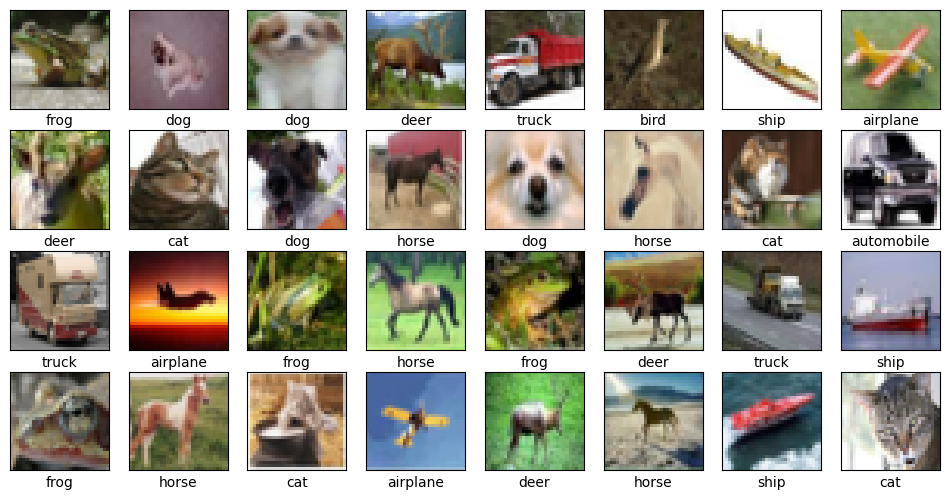

In [ ]:
visualize_data(images, labels)

#### <span style="color:#0b486b">I.2.4 View images in more detail </span>

We look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

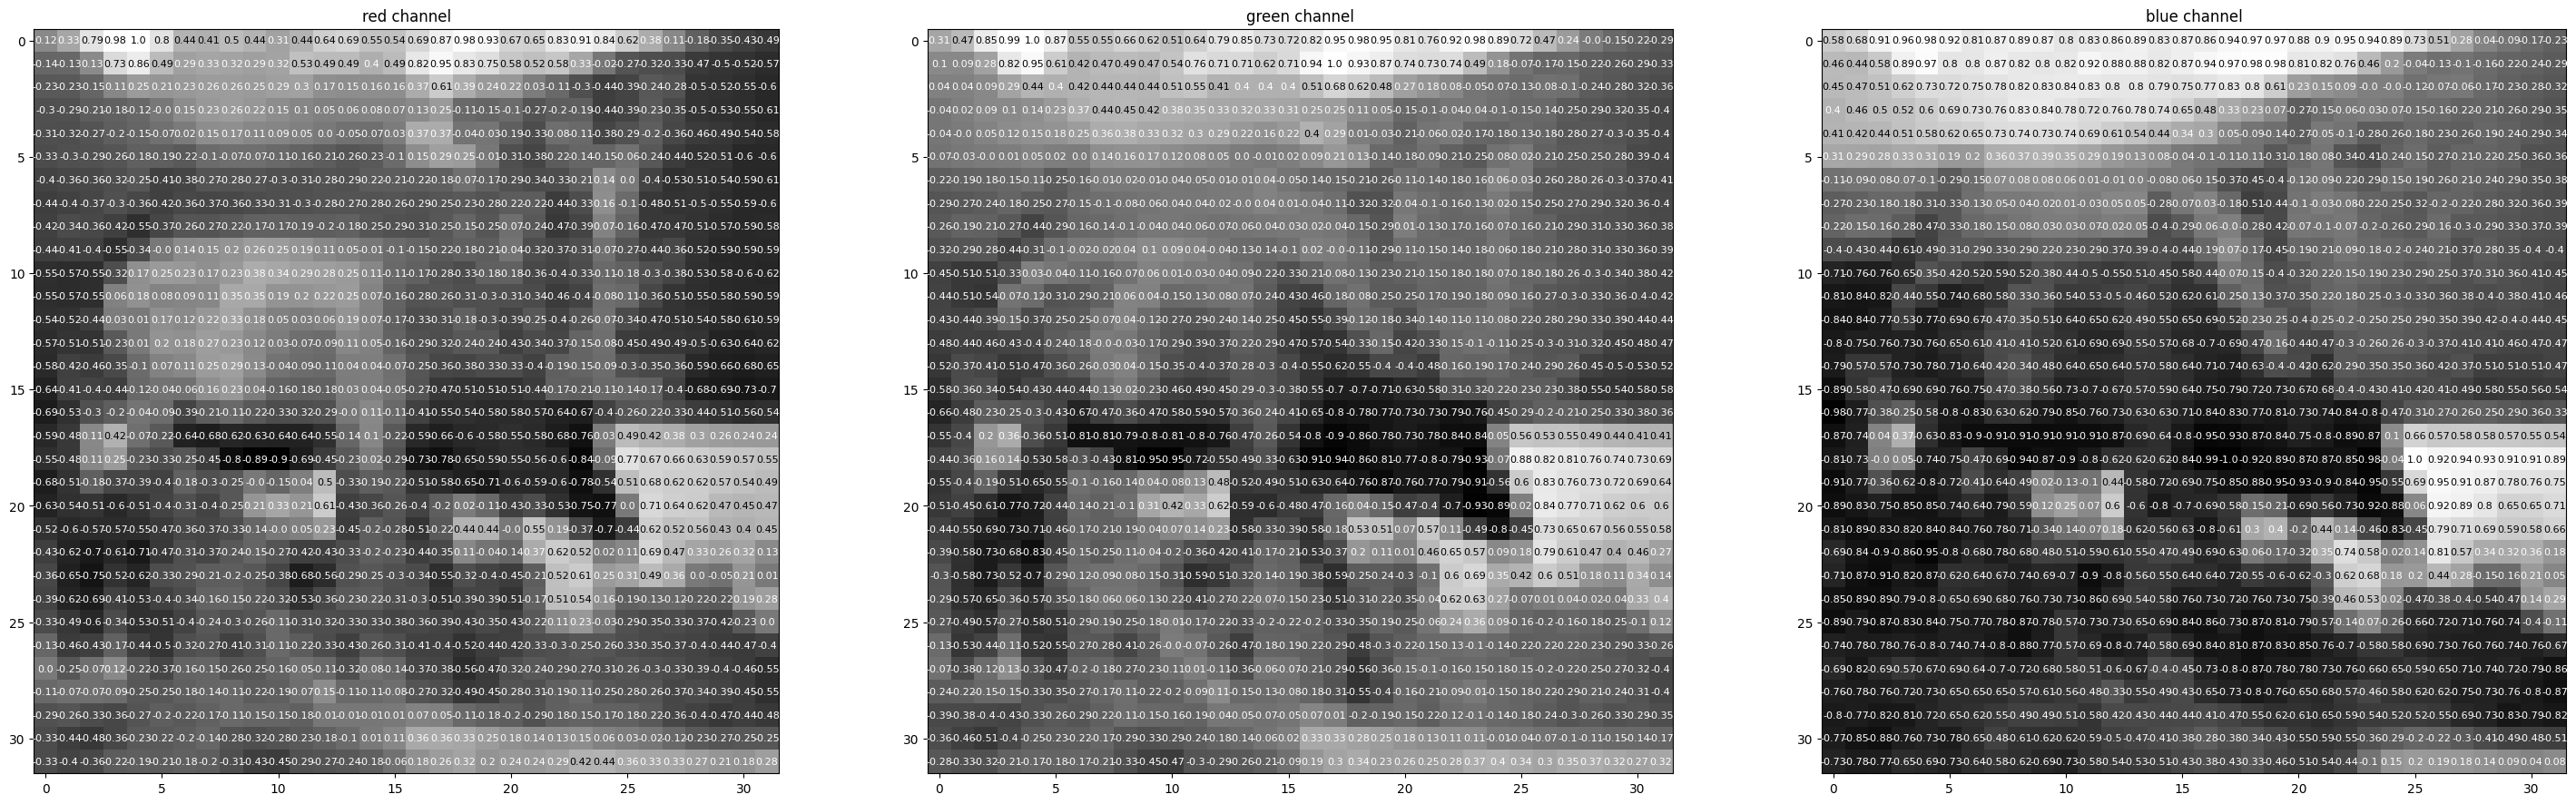

In [ ]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

#### <span style="color:#0b486b">I.2.4 Build up MiniVGG network </span>

You now build up the `MiniVGG` network. Please try to explain the shape of the tensors starting from `[3,32,32]` when going through the layers of our `MiniVGG`.

Further you can uncomment the `nn.LazyConv2D` layers and comment the corresponding `nn.Conv2D` layers. Discuss with your friends about the difference of these two layers.

**<span style="color:red">Discussion 1</span>:** What are differences of `Conv2D` layers and `LazyConv2D` layers?

**Conv2d**
- Must specify input channels at creation.
- Parameters are initialized immediately.

```
# This is formatted as code
import torch.nn as nn

conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
print(conv.weight.shape)  # torch.Size([16, 3, 3, 3])
```

**LazyConv2d**
- Don’t specify input channels.
- Parameters are initialized on first forward pass, when input shape is known.



```
# This is formatted as code

lazy_conv = nn.LazyConv2d(out_channels=16, kernel_size=3)
print(lazy_conv.has_uninitialized_params())  # True

x = torch.randn(1, 3, 32, 32)
y = lazy_conv(x)  
print(lazy_conv.weight.shape)  # torch.Size([16, 3, 3, 3])
print(lazy_conv.has_uninitialized_params())  # False

```





In [ ]:
def create_vgg():
    vgg_model = nn.Sequential(
        #Input [3, 32, 32]
        #nn.LazyConv2d(32, kernel_size=3, padding=1),
        nn.Conv2d(3, 32, kernel_size=3, padding= 1, stride =1), #[32,32,32]
        nn.BatchNorm2d(32), #[32,32,32]
        nn.ReLU(), #[32,32,32]
        #nn.LazyConv2d(32, kernel_size=3, padding=1),
        nn.Conv2d(32, 32, kernel_size=3, padding=1, stride =1), #??? [32, 32, 32]
        nn.BatchNorm2d(32), #[32, 32, 32]
        nn.ReLU(), #[32, 32, 32]
        nn.MaxPool2d(kernel_size=2), #down-sample by two #[32,16,16]
        nn.Dropout(p=0.25), #[32,16,16]

        #nn.LazyConv2d(64, kernel_size=3, padding=1),
        nn.Conv2d(32, 64 , kernel_size=3, padding=1), ##[64,16,16]
        nn.BatchNorm2d(64, momentum=0.1), ##[64,16,16]
        nn.ReLU(), #[64,16,16]
        #nn.LazyConv2d(64, kernel_size=3, padding=1)
        nn.Conv2d(64, 64, kernel_size=3, padding=1, stride= 1), #[64,16,16]
        nn.BatchNorm2d(64, momentum=0.1), #[64,16,16]
        nn.ReLU(), #[64,16,16]
        nn.LazyConv2d(64, kernel_size=3, padding=1), #[64,16,16]
        nn.BatchNorm2d(64, momentum=0.1), #[64,16,16]
        nn.ReLU(), #[64,16,16]
        nn.MaxPool2d(kernel_size=2), #down-sample by two [64,8,8]
        nn.Dropout(p=0.25),

        nn.Flatten(1),
        nn.Linear(64*8*8, 512),
        #nn.LazyLinear(512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        #nn.LazyLinear(10)
        nn.Linear(512, 10),
      )
    return vgg_model

We declare `vgg_model` as a real `MiniVGG` model and summarize the architecture of this model.

In [ ]:
vgg_model = create_vgg()

vgg_model.to(device)

print(vgg_model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1

In [ ]:
from torchsummary import summary
summary(vgg_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
           Dropout-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

Another way to implement our `MiniVGG` is to create a MiniVGG class that inherits from the base class `torch.nn.Module`.

In [ ]:
from torch import nn
import torch.nn.functional as F

class MiniVGG(torch.nn.Module):
  def __init__(self, num_classes):
    super(MiniVGG, self).__init__()
    layers = []
    layers.append(nn.Conv2d(3, 32, kernel_size=3, padding= 1)) #[32,32,32]
    layers.append(nn.BatchNorm2d(32))
    layers.append(nn.ReLU(inplace=True))
    #nn.LazyConv2d(32, kernel_size=3, padding=1),
    layers.append(nn.Conv2d(32, 32, kernel_size=3, padding=1)) #[32,32,32]
    layers.append(nn.BatchNorm2d(32))
    layers.append(nn.ReLU(inplace = True))
    layers.append(nn.MaxPool2d(kernel_size=2)) #down-sample by two #[32,16,16]
    layers.append(nn.Dropout(p=0.25))
    #nn.LazyConv2d(64, kernel_size=3, padding=1),
    layers.append(nn.Conv2d(32, 64 , kernel_size=3, padding=1)) #[64,16,16]
    layers.append(nn.BatchNorm2d(64))
    layers.append(nn.ReLU(inplace = True))
    #nn.LazyConv2d(64, kernel_size=3, padding=1)
    layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1)) #[64,16,16]
    layers.append(nn.BatchNorm2d(64))
    layers.append(nn.ReLU(inplace = True))
    layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1)) #[64,16,16]
    layers.append(nn.BatchNorm2d(64))
    layers.append(nn.ReLU(inplace= True)),
    layers.append(nn.MaxPool2d(kernel_size=2)), #down-sample by two [64,8,8]
    layers.append(nn.Dropout(p=0.25))
    layers.append(nn.Flatten(1)) #64x8x8
    layers.append(nn.LazyLinear(512))
    layers.append(nn.BatchNorm1d(512))
    layers.append(nn.ReLU(inplace = True))
    layers.append(nn.LazyLinear(num_classes))
    self.block = nn.ModuleList(layers)


  def forward(self,x):
    for layer in self.block:
      x = layer(x)
    return x

We create a real `vgg_model` and summarize its architecture.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg_model = MiniVGG(num_classes=10)

vgg_model = vgg_model.to(device)

print(vgg_model)

MiniVGG(
  (block): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [ ]:
# Loss and optimizer
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=learning_rate)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_loss(model, loss_fn, loader):
  loss = 0
  # Set model to eval mode for inference
  model.eval()
  with torch.no_grad():  # No need to track gradients for validation
    for (batchX, batchY) in loader:
      # Move data to the same device as the model
      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      loss += loss_fn(model(batchX), batchY)
  # Set model back to train mode
  model.train()
  return float(loss)/len(loader)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_acc(model, loader):
    correct = 0
    totals = 0
    # Set model to eval mode for inference
    model.eval()
    for (batchX, batchY) in loader:
        # Move batchX and batchY to the same device as the model
        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)  # feed batch to the model
        totals += batchY.size(0)  # accumulate totals with the current batch size
        predicted = torch.argmax(outputs.data, 1)  # get the predicted class
        # Move batchY to the same device as predicted for comparison
        correct += (predicted == batchY).sum().item()
    return correct / totals

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, seed= 1234):
  torch.manual_seed(seed)
  # Move the model to the device before initializing the optimizer
  model.to(device)
  if optimizer == None:
    optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
  else:
    optim = optimizer
  history = dict()
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
      model.train() #set the model to the training mode
      for (X, y) in train_loader:
          # Move input data to the same device as the model
          X,y = X.to(device), y.to(device)
          # Forward pass
          outputs = model(X.type(torch.float32))
          loss = loss_fn(outputs, y.type(torch.long))
          # Backward and optimize
          optim.zero_grad()
          loss.backward()
          optim.step()
      #losses and accuracies for epoch
      val_loss = compute_loss(model, loss_fn, valid_loader)
      val_acc = compute_acc(model, valid_loader)
      train_loss = compute_loss(model, loss_fn, train_loader)
      train_acc = compute_acc(model, train_loader)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)
      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      if verbose: #verbose = True means we do show the training information during training
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
  return history

We now train the model in `30` epochs. Please change your Runtime to `GPU` if you can.

In [ ]:
history = fit(model= vgg_model, train_loader=train_loader, valid_loader = valid_loader,
    optimizer = optimizer, num_epochs= 30, verbose = True)

Epoch 1/30
train loss= 1.5231 - train acc= 46.62% - valid loss= 1.6297 - valid acc= 42.04%
Epoch 2/30
train loss= 1.0971 - train acc= 61.74% - valid loss= 1.3175 - valid acc= 52.64%
Epoch 3/30
train loss= 0.8970 - train acc= 68.88% - valid loss= 1.2577 - valid acc= 55.52%
Epoch 4/30
train loss= 0.9545 - train acc= 67.16% - valid loss= 1.4656 - valid acc= 52.00%
Epoch 5/30
train loss= 0.4683 - train acc= 86.74% - valid loss= 1.0670 - valid acc= 62.30%
Epoch 6/30
train loss= 0.5531 - train acc= 80.04% - valid loss= 1.3480 - valid acc= 56.10%
Epoch 7/30
train loss= 0.2384 - train acc= 93.70% - valid loss= 1.1238 - valid acc= 62.82%
Epoch 8/30
train loss= 0.2060 - train acc= 94.96% - valid loss= 1.2466 - valid acc= 60.54%
Epoch 9/30
train loss= 0.1288 - train acc= 97.10% - valid loss= 1.2175 - valid acc= 62.64%
Epoch 10/30
train loss= 0.0768 - train acc= 99.02% - valid loss= 1.1883 - valid acc= 64.08%
Epoch 11/30
train loss= 0.0609 - train acc= 98.88% - valid loss= 1.2646 - valid acc= 64.5

We now can evaluate the performance on the CIFAR-10 test set.

In [ ]:
test_acc = compute_acc(model = vgg_model, loader= test_loader)
print(f"Test acc = {test_acc*100:.2f}%")

Test acc = 65.42%


**<span style="color:red">Discussion 2</span>:** What are the purposes of `model.eval()` and `model.train()`? Why are they important in training and evaluating our CNNs?

**model.train()**
- Sets the model to training mode.
- Affects certain layers that behave differently during training vs. testing:
  - Dropout → randomly drops units to prevent overfitting.
  - BatchNorm → updates running mean/variance with the current batch.
- Needed before running the training loop.

**model.eval()**
- Sets the model to evaluation (inference) mode.
- Changes behavior of some layers:
  - Dropout → turned off (no random dropping).
  - BatchNorm → uses learned running statistics instead of batch stats.
- Needed before validation/testing/prediction.

### <span style="color:#0b486b">I.2.5 Plot training loss and accuracy</span> ###

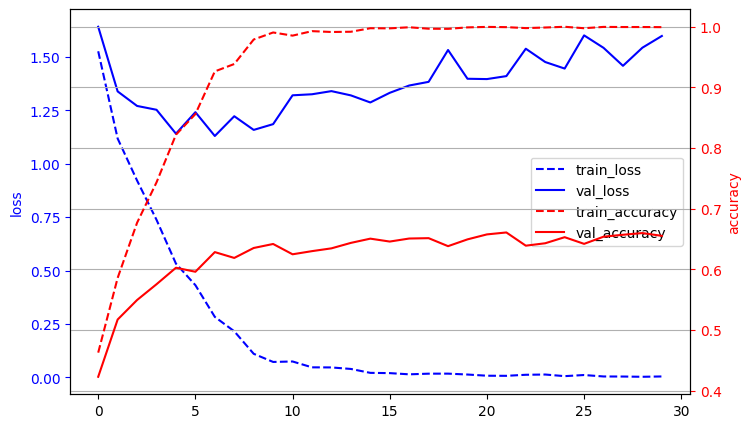

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

his = history
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ln1 = ax.plot(his['train_loss'], 'b--',label='train_loss')
ln2 = ax.plot(his['val_loss'], 'b-',label='val_loss')
ax.set_ylabel('loss', color='blue')
ax.tick_params(axis='y', colors="blue")

ax2 = ax.twinx()
ln3 = ax2.plot(his['train_acc'], 'r--',label='train_accuracy')
ln4 = ax2.plot(his['val_acc'], 'r-',label='val_accuracy')
ax2.set_ylabel('accuracy', color='red')
ax2.tick_params(axis='y', colors="red")

lns = ln1 + ln2 + ln3 + ln4
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc=7)
plt.grid(True)
plt.show()

---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>